## 用于测试各种核方法或者其他计算propensity scores的方法


In [1]:
from sklearn import linear_model
from scipy.sparse import coo_matrix
from scipy.stats import ttest_rel, binom
from scipy.stats import chi2
import numpy as np
from math import log
import sys

import sklearn.metrics.pairwise
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
filename = "data/data1_movie_stopwords.txt"
param_reg = 1.0
param_thresh = 100000.0

word_docs = {}
docs_word = []
vocab = {}
l = 0
iter_num = 1000

for line in open(filename):
    if l >= iter_num:
        break
    tokens = line.strip().split()
    docs_word.append(tokens[1 : ])
    for word in set(tokens[1 : ]):
        if word not in vocab:
            vocab[word] = len(vocab)
        if word not in word_docs:
            word_docs[word] = []
        word_docs[word].append(l)
    
    l += 1
    
L = l
V = len(vocab)

print("%d documents, %d distinct word types" % (L, V))

1000 documents, 9114 distinct word types


In [3]:
vocab

{'surprisingly': 0,
 'raised': 1,
 'story': 2,
 'booked': 3,
 'effects': 4,
 'superhero': 5,
 'genuinely': 6,
 'even': 7,
 'love': 8,
 'faces': 9,
 '10': 10,
 'movies': 11,
 'music': 12,
 'see': 13,
 'fan': 14,
 'blew': 15,
 'fantastic': 16,
 'cast': 17,
 'eyebrow': 18,
 'words': 19,
 'andy': 20,
 'felt': 21,
 'plenty': 22,
 'renewed': 23,
 'exciting': 24,
 'well': 25,
 'franchise': 26,
 'somehow': 27,
 'play': 28,
 'acting': 29,
 'saw': 30,
 'eat': 31,
 'already': 32,
 'admit': 33,
 'known': 34,
 'special': 35,
 'serkis': 36,
 'fast': 37,
 'film': 38,
 'pattinson': 39,
 'part': 40,
 'throughout': 41,
 'great': 42,
 'hopefully': 43,
 'awesome': 44,
 'away': 45,
 'times': 46,
 'paced': 47,
 'gritty': 48,
 'would': 49,
 'robert': 50,
 'unrecognisable': 51,
 'day': 52,
 'believed': 53,
 'plot': 54,
 'trying': 55,
 'dark': 56,
 'colin': 57,
 'disappointed': 58,
 'long': 59,
 'dano': 60,
 'tried': 61,
 'batman': 62,
 'place': 63,
 'usually': 64,
 'defended': 65,
 'knight': 66,
 'movie': 67,

In [4]:
word_docs

{'surprisingly': [0,
  96,
  160,
  188,
  202,
  374,
  535,
  554,
  571,
  584,
  606,
  618,
  661,
  715,
  809,
  876],
 'raised': [0, 93, 588],
 'story': [0,
  2,
  7,
  9,
  10,
  12,
  16,
  19,
  22,
  24,
  29,
  34,
  41,
  42,
  46,
  51,
  52,
  53,
  54,
  56,
  59,
  61,
  63,
  66,
  67,
  73,
  74,
  83,
  84,
  89,
  90,
  91,
  93,
  94,
  96,
  98,
  101,
  104,
  106,
  107,
  111,
  112,
  113,
  115,
  116,
  117,
  118,
  122,
  124,
  125,
  137,
  138,
  139,
  140,
  143,
  147,
  152,
  163,
  167,
  168,
  169,
  171,
  174,
  181,
  187,
  188,
  189,
  196,
  197,
  202,
  203,
  204,
  205,
  215,
  220,
  225,
  235,
  236,
  241,
  246,
  250,
  252,
  253,
  256,
  258,
  259,
  260,
  261,
  262,
  263,
  266,
  272,
  275,
  281,
  285,
  288,
  291,
  295,
  297,
  302,
  303,
  307,
  312,
  318,
  335,
  338,
  339,
  340,
  349,
  351,
  357,
  358,
  359,
  360,
  369,
  370,
  374,
  376,
  380,
  381,
  382,
  399,
  403,
  405,
  409,
  411

In [5]:
treatment = "great"

rows = []
cols = []
values = []
y = []

for line in range(iter_num):

    contains_treatment = 0
    for word in docs_word[line]:
        if word == treatment:
            contains_treatment = 1
        else:
            rows.append(line)
            cols.append(vocab[word])
            values.append(1.0)
    y.append(contains_treatment)
    
x = coo_matrix((values, (rows, cols)), shape = (iter_num, V)).toarray()
print(x.shape)

(1000, 9114)


In [6]:
class Model(object):
    def __init__(self, kernel = "linear", C = 1.0, gamma = 'auto', degree = 3, coef0 = 0., anova = False, percentile = 10):
        self.kernel = kernel
        self.C = C
        self.gamma = gamma
        self.degree = degree
        self.coef0 = coef0
        self.anova = anova
        self.percentile = percentile
        if anova:
            self.model = Pipeline(
                [
                    ("anova", SelectPercentile()),
                    ("scaler", StandardScaler()),
                    ("svc", svm.SVC(kernel = self.kernel, C = self.C, gamma = self.gamma, 
                                    degree = self.degree, coef0 = self.coef0, probability = True))
                ]
            )
        else:
            self.model = svm.SVC(kernel = self.kernel, C = self.C, gamma = self.gamma, 
                                 degree = self.degree, coef0 = self.coef0, probability = True)
        
    def fit(self, x, y):
        self.model.fit(x, y)
        
    def predict_proba(self, x):
        return self.model.predict_proba(x)

In [7]:
def plt_hist(scores, y, coef = np.zeros((4, 2)), output = False):
    plt.figure(figsize=(15,7))
    plt.hist(scores[[i for i, x in zip(range(len(y)), y) if x == 0]], bins=50, label='Negatives')
    plt.hist(scores[[i for i, x in zip(range(len(y)), y) if x == 1]], bins=50, label='Positives', alpha = 0.7, color='r')
    plt.xlabel('Probability of being Positive Class', fontsize=25)
    plt.ylabel('Number of records in each bucket', fontsize=25)
    plt.legend(fontsize=15)
    plt.tick_params(axis='both', labelsize=25, pad=5)
    if output:
        coef_str = '_'.join('_'.join(str(int(x)) for x in line) for line in coef)
        plt.title(coef_str)
        imagepath = 'images/coef' + coef_str + '.png'
        plt.savefig(imagepath)
    else:
        plt.show() 

## Logistic Regression

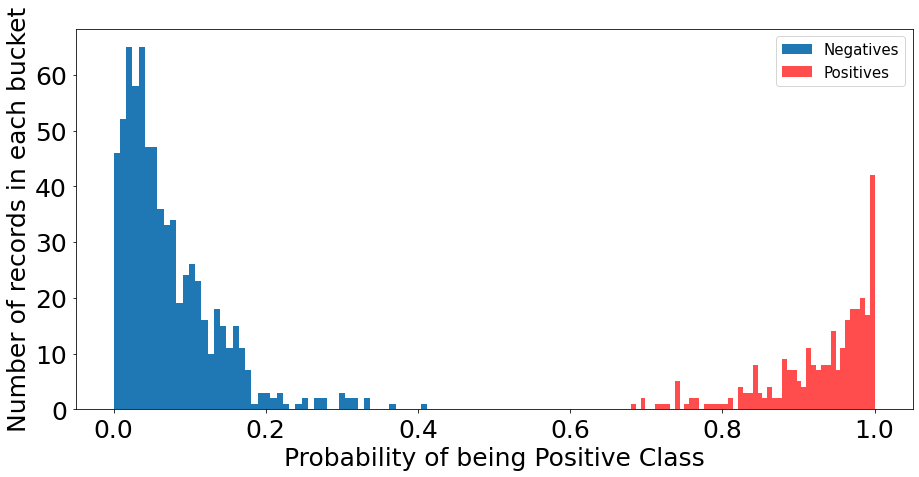

In [8]:
initial_model = linear_model.LogisticRegression(class_weight = 'balanced')
initial_model.fit(x, y)
initial_scores = initial_model.predict_proba(x)[ : , 1]
plt_hist(initial_scores, y)

## Hyperplane for unbalanced classes

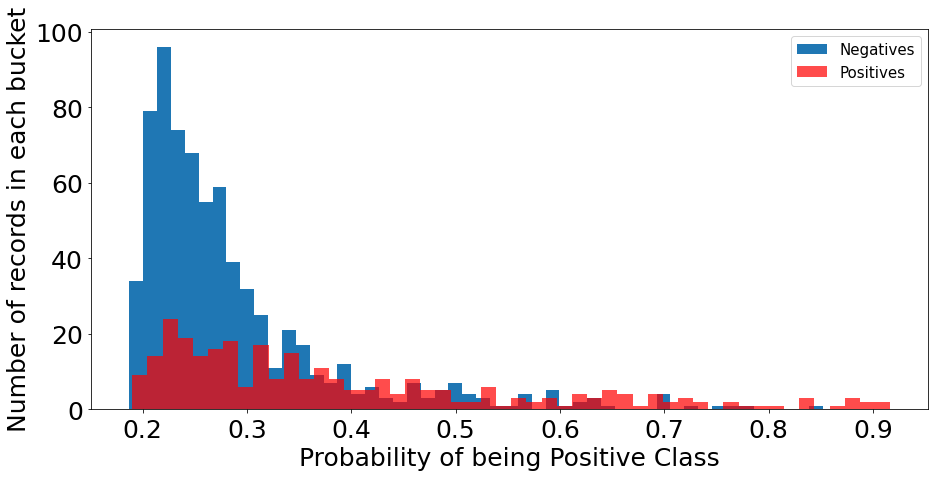

In [9]:

clf = svm.SVC(kernel = "sigmoid", C = 1, gamma = 0.001, degree = 2, coef0 = 10, probability = True)
clf.fit(x, y)
scores = clf.predict_proba(x)[ : , 1]
plt_hist(scores, y)

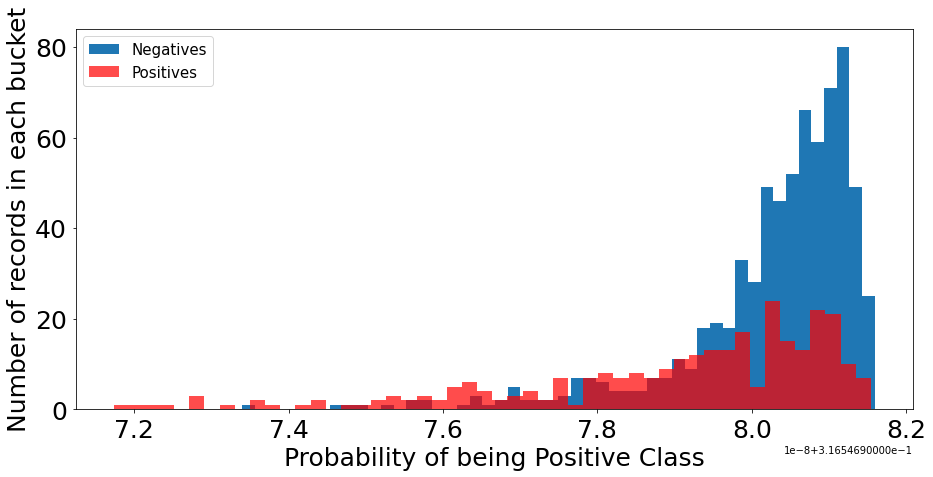

In [10]:
clf = svm.SVC(kernel = "sigmoid", C = 1, gamma = 0.001, degree = 2, coef0 = 10, probability = True, class_weight = 'balanced')
clf.fit(x, y)
scores = clf.predict_proba(x)[ : , 1]
plt_hist(scores, y)

## Gaussian kernel

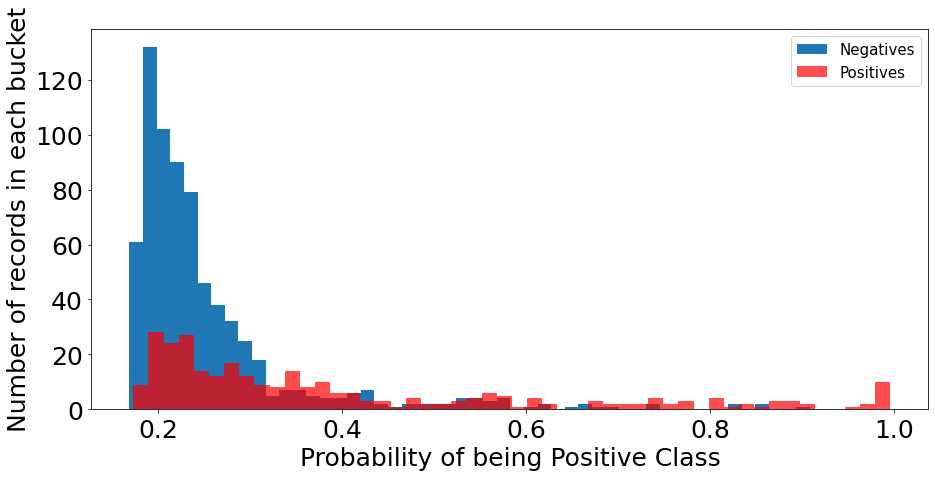

In [11]:
model = Model(kernel = 'rbf')
model.fit(x, y)
scores = model.predict_proba(x)[ : , 1]
plt_hist(scores, y)

## Polynomial kernel (default: degree = 3)

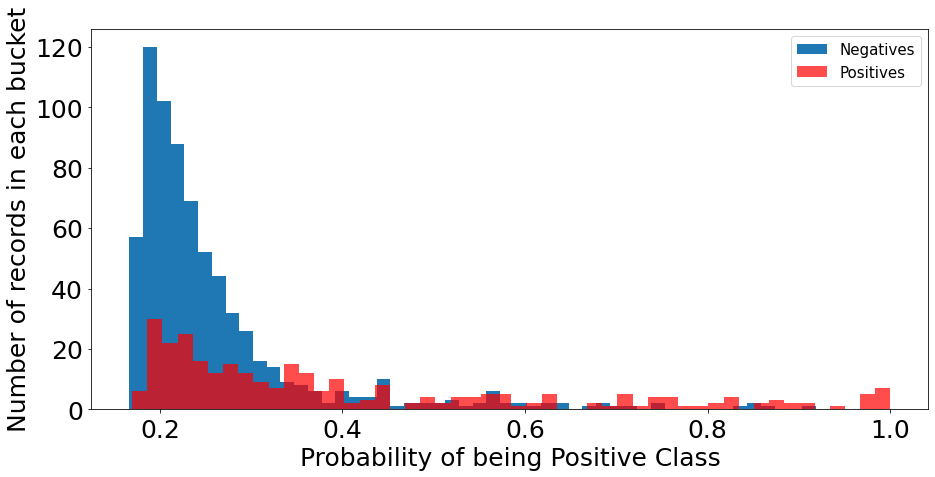

In [12]:
model = Model(kernel = 'poly', degree = 1)
model.fit(x, y)
scores = model.predict_proba(x)[ : , 1]
plt_hist(scores, y)

## Sigmoid kernel

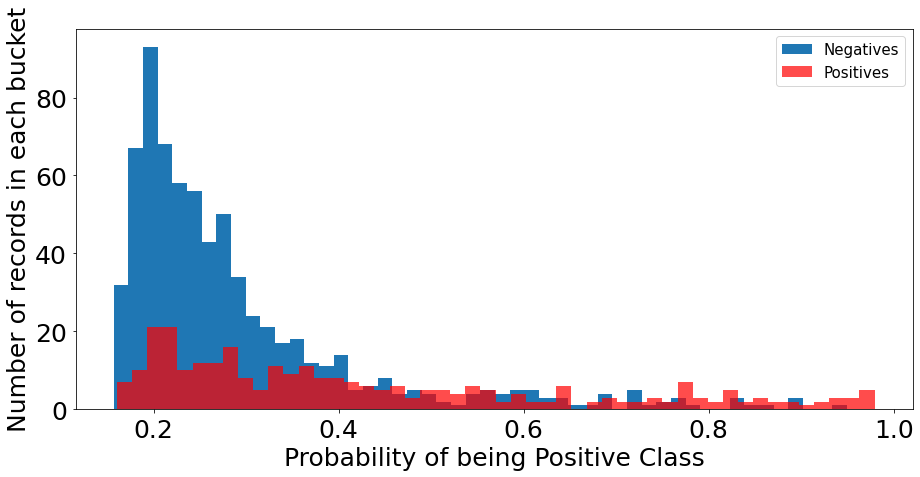

In [13]:
model = Model(kernel = 'sigmoid', gamma = 0.001, coef0 = 10)
model.fit(x, y)
scores = model.predict_proba(x)[ : , 1]
plt_hist(scores, y)

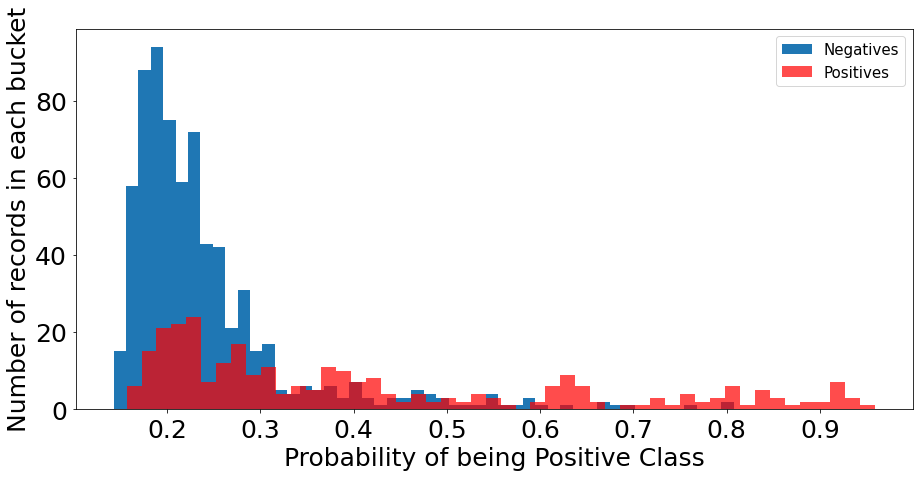

In [14]:
model = Model(kernel = 'sigmoid', gamma = 0.0009)
model.fit(x, y)
scores = model.predict_proba(x)[ : , 1]
plt_hist(scores, y)

## Linear kernel

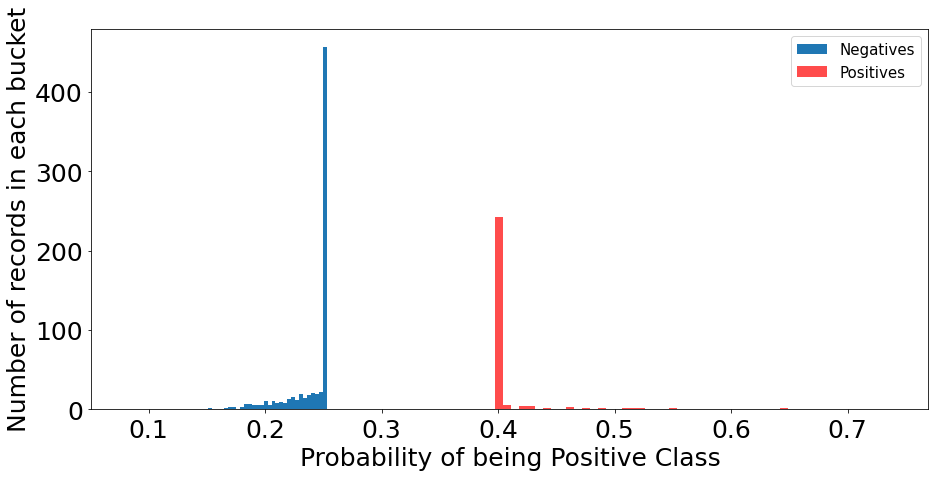

In [15]:
model = Model()
model.fit(x, y)
scores = model.predict_proba(x)[ : , 1]
plt_hist(scores, y)

## Gaussian kernel with LogisticRegression

(1000, 9114)


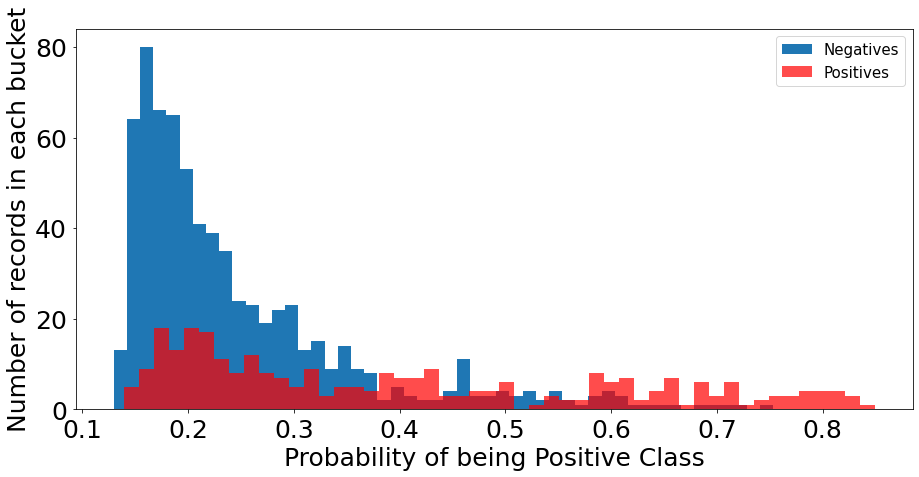

In [16]:
model = linear_model.LogisticRegression(C=1)
print(x.shape)
new_x = sklearn.metrics.pairwise.rbf_kernel(x, x, gamma = 0.0015)
model.fit(new_x, y)
scores = model.predict_proba(new_x)[ : , 1]
plt_hist(scores, y)

## Polynomial kernel with LogisticRegression

C:\Users\Fir\.conda\envs\d2l\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


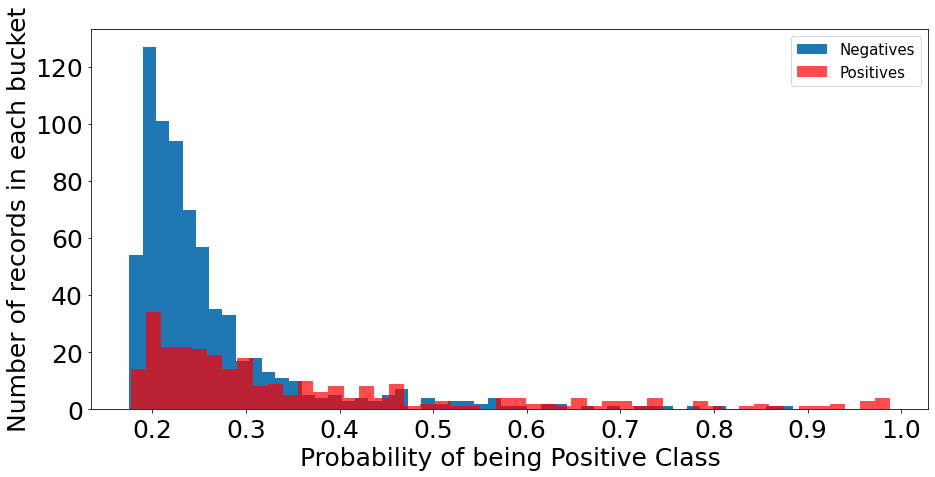

In [17]:

x_ = sklearn.metrics.pairwise.polynomial_kernel(x, x, degree = 3)
model.fit(x_, y)
scores = model.predict_proba(x_)[ : , 1]
plt_hist(scores, y)

## Linear kernel with LogisticRegression

C:\Users\Fir\.conda\envs\d2l\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


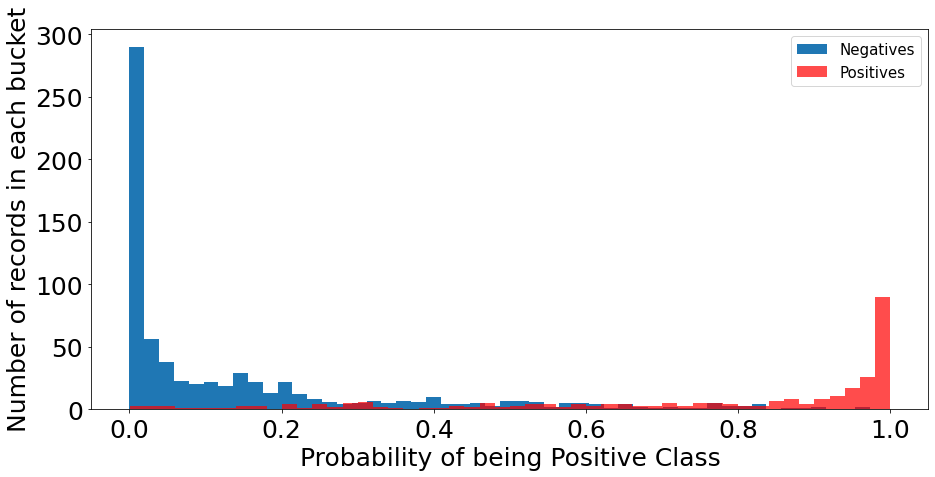

In [18]:

x_ = sklearn.metrics.pairwise.linear_kernel(x, x)
model.fit(x_, y)
scores = model.predict_proba(x_)[ : , 1]
plt_hist(scores, y)

## Sigmoid kernel with LogisticRegression

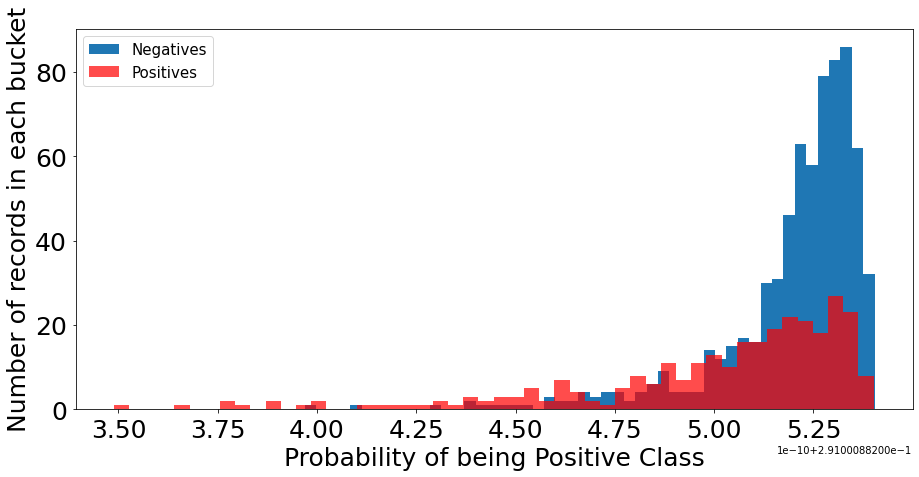

In [19]:

x_ = sklearn.metrics.pairwise.sigmoid_kernel(x, x, gamma = 0.001, coef0 = 10)
model.fit(x_, y)
scores = model.predict_proba(x_)[ : , 1]
plt_hist(scores, y)

## Linear combination of kernels

In [20]:

x_rbf = sklearn.metrics.pairwise.rbf_kernel(x, x, gamma = 0.0015)
x_linear = sklearn.metrics.pairwise.linear_kernel(x, x)
x_poly = sklearn.metrics.pairwise.polynomial_kernel(x, x, degree = 2)
x_sigmoid = sklearn.metrics.pairwise.sigmoid_kernel(x, x, gamma = 0.0001)

C:\Users\Fir\.conda\envs\d2l\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


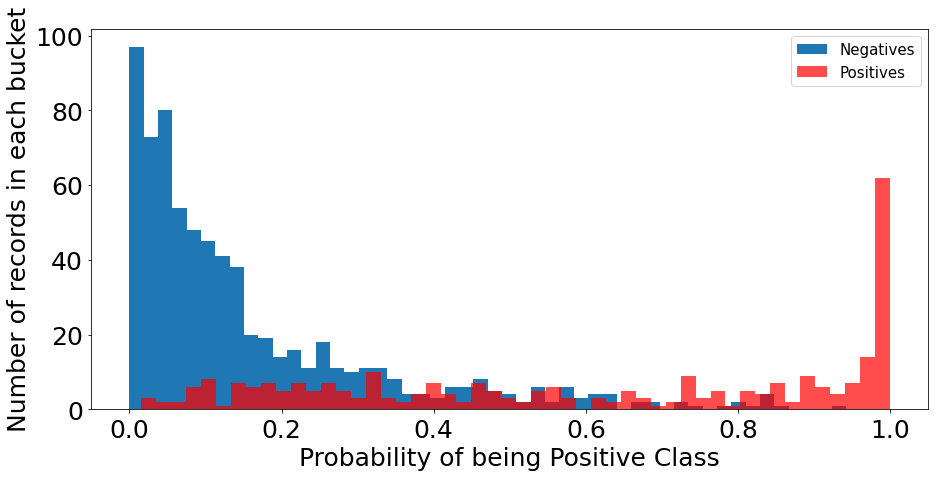

In [21]:
a = 1
b = 1
c = 1
d = 1
x_new = a * x_rbf + b * x_linear + c * x_poly + d * x_sigmoid
model.fit(x_new, y)
scores = model.predict_proba(x_new)[ : , 1]
plt_hist(scores, y)

C:\Users\Fir\.conda\envs\d2l\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


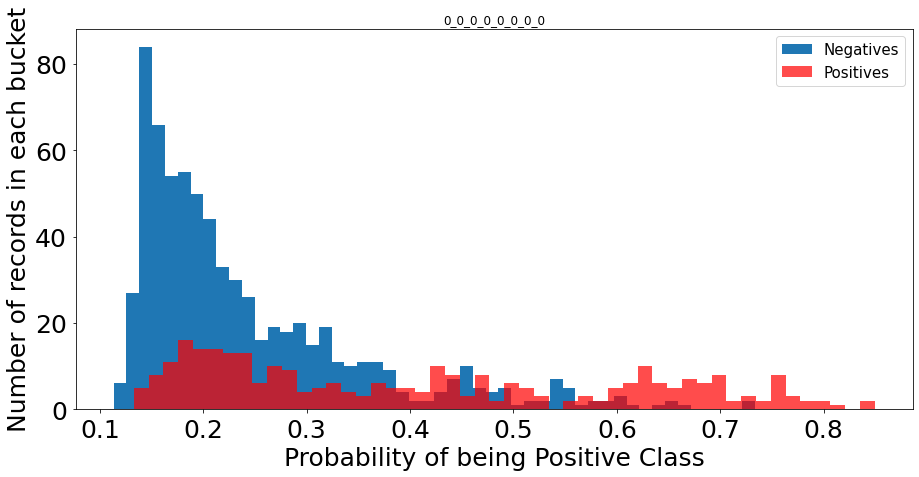

In [22]:
x_new = a * x_rbf ** 1.5
model.fit(x_new, y)
scores = model.predict_proba(x_new)[ : , 1]
plt_hist(scores, y, output = True)

In [23]:
# for a in range(1, 4):
#     for b in range(1, 4):
#         for c in range(1, 4):
#             for d in range(1, 4):
#                 for e in range(1, 4):
#                     for f in range(1, 4):
#                         for g in range(1, 4):
#                             for h in range(1, 4):
#                                 x_new = a * x_rbf ** b + c * x_linear ** d + e * x_poly ** f + g * x_sigmoid ** h
#                                 model.fit(x_new, y)
#                                 scores = model.predict_proba(x_new)[ : , 1]
#                                 coef = np.array([a, b, c, d, e, f, g, h]).reshape(4, 2)
#                                 plt_hist(scores, y, coef = coef, output = True)

## Logistic Regression (self-defined sigmoid function)

In [24]:
import scipy.stats

class LR(object):
    def __init__(self, learning_rate = 0.1, max_iter = 1000, seed = None, sigmoid_range = [0., 1.],beta = 1.0):
        self.seed = seed
        self.lr = learning_rate
        self.max_iter = max_iter
        self.sigmoid_range_l = sigmoid_range[0] if sigmoid_range[0] >= 0. and sigmoid_range[0] <= 1.0 else 0.
        self.sigmoid_range_r = sigmoid_range[1] if sigmoid_range[1] >= 0. and sigmoid_range[1] <= 1.0 else 1.
        self.beta : int = beta
        
    def fit(self, x, y):
        np.random.seed(self.seed)
        self.w = np.random.normal(loc = 0., scale = 1., size = x.shape[1])
        self.b = np.random.normal(loc = 0., scale = 1.)
        self.x = x
        self.y = y
        for i in range(self.max_iter):
            self.update()
            
    def update(self):
        dw, db = self.calc_gradient()
        self.w = self.w - self.lr * dw
        self.b = self.b - self.lr * db
        return self.w, self.b
    
    def calc_gradient(self):
        y_pred = self.predict()
        dw = (y_pred - self.y).dot(self.x) / len(self.y)
        db = np.mean(y_pred - self.y)
        return dw, db
    
    def predict(self, x = None):
        if x is None:
            x = self.x
        y_pred_proba = self.f(x, self.w, self.b)
        y_pred = np.array([1 if y_pred_proba[i] > 0.5 else 0 for i in range(len(y_pred_proba))])
        return y_pred
    
    def f(self, x, w, b):
        z = x.dot(w) + b
        sigmoid = self.sigmoid(z)
        distribution = np.array([[1 - sigmoid[i], sigmoid[i]] if self.y[i] else [sigmoid[i], 1 - sigmoid[i]] for i in range(len(sigmoid))])
        kl = np.array(scipy.stats.entropy(distribution, [1 / 2, 1 / 2], axis = 1))
        shift = np.array([kl[i] * (0.5 - sigmoid[i]) for i in range(len(sigmoid))])
        shift_ = np.array([0.5 - sigmoid[i] for i in range(len(sigmoid))])
        sigmoid += self.beta * shift
        return  (self.sigmoid_range_r - self.sigmoid_range_l) * sigmoid + self.sigmoid_range_l
    
    def sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-z))
    
    def predict_proba(self, x = None):
        if x is None:
            x = self.x
        y_pred = self.f(x, self.w, self.b)
        return y_pred
    
    def loss(self, y_true = None, y_pred_proba = None):
        if y_true is None or y_pred is None:
            y_true = self.y
            y_pred_proba = self.predict_proba()
        return np.mean(-1.0 * (y_true * np.log(y_pred_proba) + (1.0 - y_true) * np.log(1.0 - y_pred_proba)))

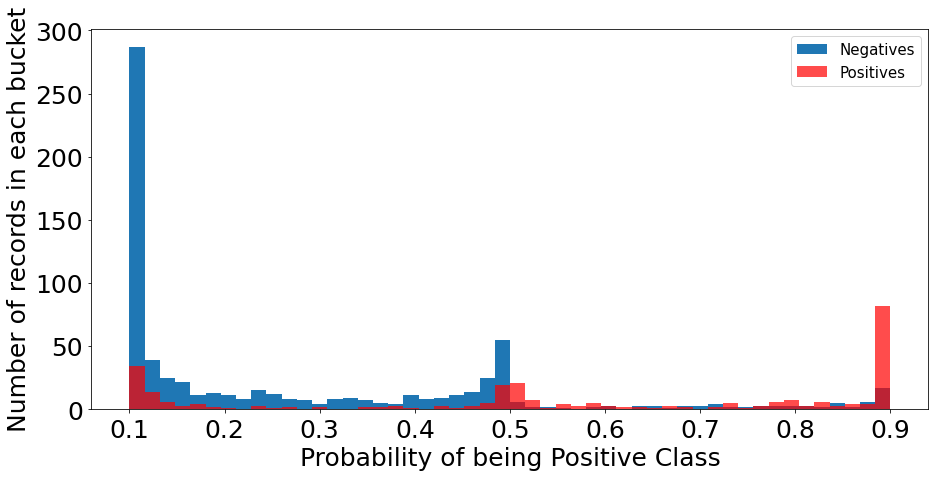

In [25]:
model = LR(max_iter = 1000, sigmoid_range = [0.1, 0.9], beta = .0)
model.fit(x, y)
scores = model.predict_proba(x)
plt_hist(scores, y)

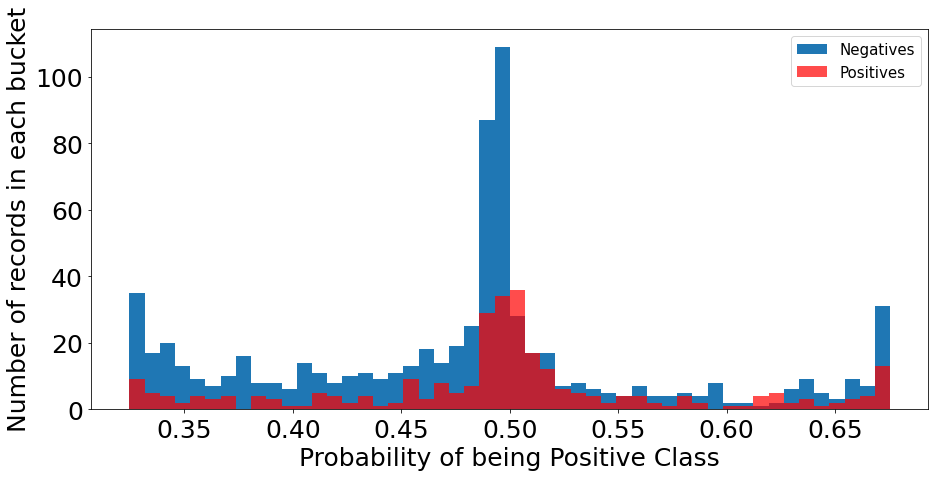

In [26]:
model = LR(max_iter = 200, sigmoid_range = [0.1, 0.9], beta = 1.42)
model.fit(x, y)
scores = model.predict_proba(x)
plt_hist(scores, y)

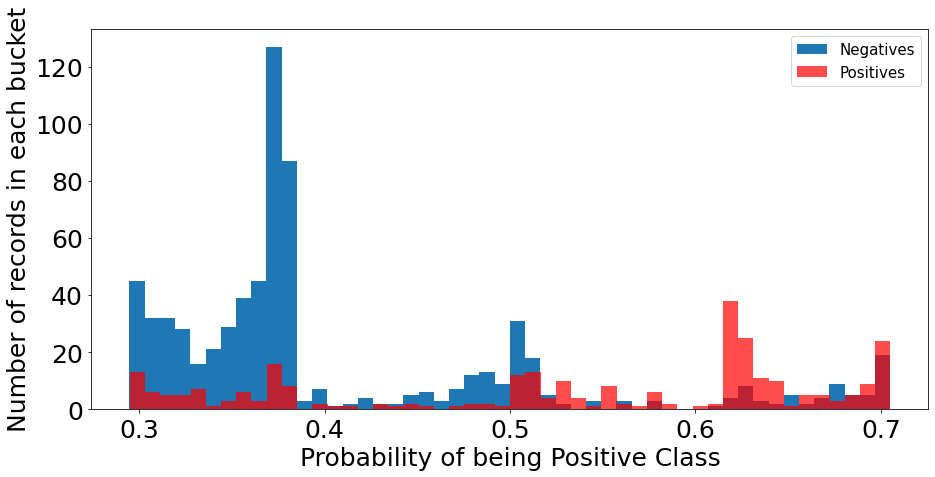

In [27]:
model = LR(max_iter = 1000, sigmoid_range = [0.1, 0.9], beta = 1.0)
model.fit(x, y)
scores = model.predict_proba(x)
plt_hist(scores, y)

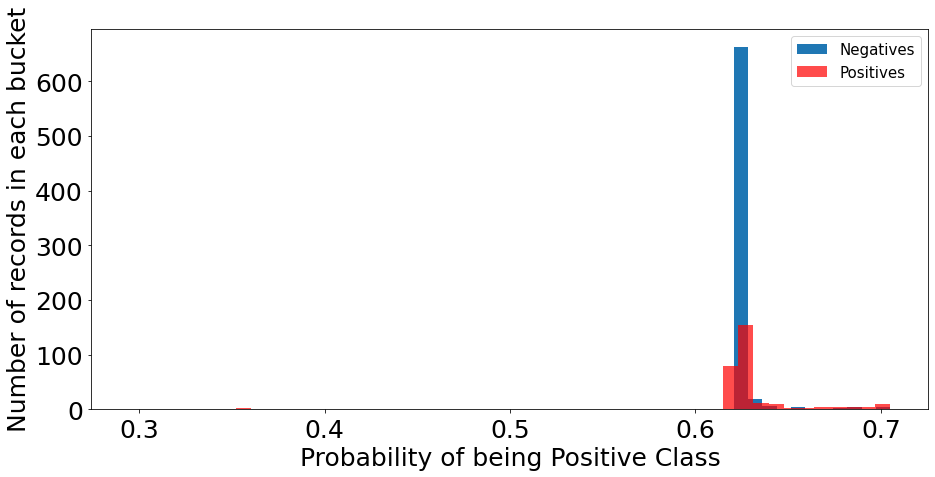

In [28]:
model = LR(max_iter = 100, sigmoid_range = [0.1, 0.9], beta = 1.0)
model.fit(x_new, y)
scores = model.predict_proba(x_new)
plt_hist(scores, y)

In [29]:
x.shape

(1000, 9114)

In [30]:
scipy.stats.entropy([[0.99, 0.01], [1 / 2, 1 / 2]], [0.01, 0.99], axis = 1)

array([4.50321745, 1.61446308])